#**Truck Sales 🚛 for Time Series**
*Author*: **Billel Khiri**
*Groupe*: **1**

#**Abstract**
This project explores time series analysis of historical truck sales data to forecast future sales trends. The dataset spans several decades, capturing annual truck sales figures over time. Our objective is to develop a predictive model that accurately estimates future truck sales based on historical trends. By analyzing past patterns, we aim to provide insights that support business decision-making, inventory management, and market strategy optimization.

#**Introduction**
The trucking industry plays a vital role in global logistics and commerce, facilitating the transportation of goods across vast distances. Understanding sales trends in the truck market is crucial for manufacturers, dealers, and policymakers to make informed decisions. Various factors, including economic conditions, fuel prices, and industry regulations, can influence truck sales patterns.

This study focuses on analyzing long-term trends in truck sales data using time series analysis. By examining historical sales figures, we aim to identify trends, potential seasonality, and external factors affecting demand fluctuations. The ultimate goal is to develop a forecasting model that can provide accurate sales predictions. Through this analysis, we seek to contribute to market insights that can enhance sales strategies, production planning, and overall business efficiency

#**1-Data Selection**

In [64]:

install.packages(c("readr", "ggplot2", "forecast", "tseries", "urca"))
install.packages("astsa")
install.packages('TSA')
install.packages("faraway")
install.packages("Metrics")

library(Metrics)
library(readr)
library(ggplot2)
library(forecast)
library(tseries)
library(urca)
library(astsa)


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [65]:
data <- read.csv("Truck_sales.csv")

str(data)

'data.frame':	144 obs. of  2 variables:
 $ Month.Year        : chr  "03-Jan" "03-Feb" "03-Mar" "03-Apr" ...
 $ Number_Trucks_Sold: int  155 173 204 219 223 208 228 228 188 165 ...


** bold textSource of the data:**
https://www.kaggle.com/datasets/ddosad/dummy-truck-sales-for-time-series

The dataset contains historical truck sales data, focusing on the date of sales and corresponding prices.

Date: The specific date when truck sales were recorded.

Price: The recorded price of the trucks sold on that date.

This dataset serves as a basis for analyzing truck sales trends over time. Using time series analysis, we aim to identify patterns, trends, and possible seasonality in truck pricing. The insights derived from this study can help businesses in pricing strategy optimization and market trend forecasting.

##1.2- convert data to time **series**

In [66]:
ts_data <- ts(data$Number_Trucks_Sold, start=c(2003, 1),frequency = 12)
print(head(ts_data))


     Jan Feb Mar Apr May Jun
2003 155 173 204 219 223 208


We set the frequency to 12 because we have monthly data.

##1.3- Plot the time series data



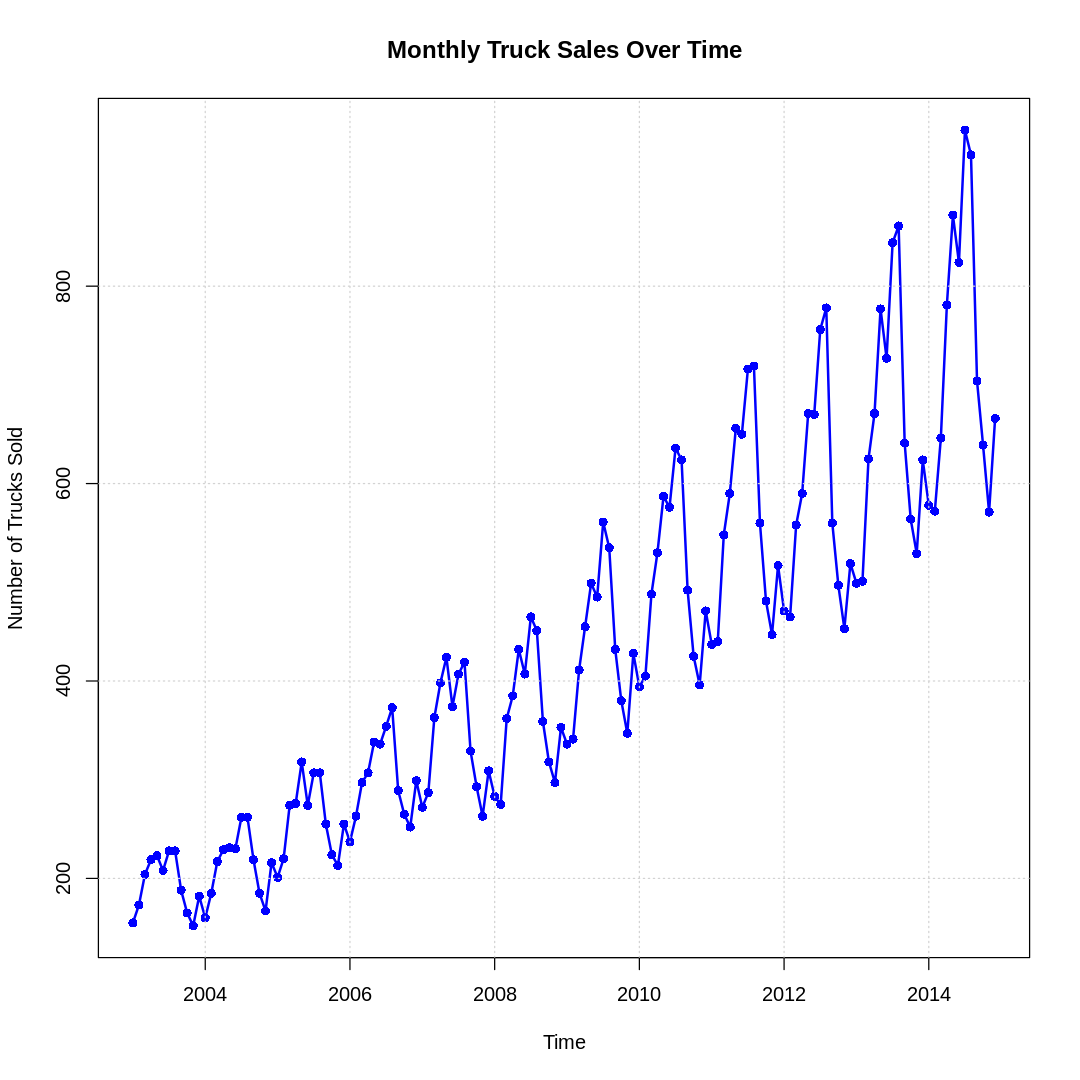

In [67]:
plot(ts_data, type="o", col="blue", lwd=2, pch=16,
     xlab="Time", ylab="Number of Trucks Sold",
     main="Monthly Truck Sales Over Time")
grid()
options(repr.plot.width=9, repr.plot.height=9)


After visualizing the data, we observe a clear seasonal pattern and a pronounced upward linear trend, indicating that the series is non-stationary. Additionally, the variance appears to be increasing over time, suggesting possible heteroscedasticity.

##1.4- Data Decomposition
To separate the trend, seasonality and noise components or remainders, we use a technique called STL decomposition provided by R as stl:

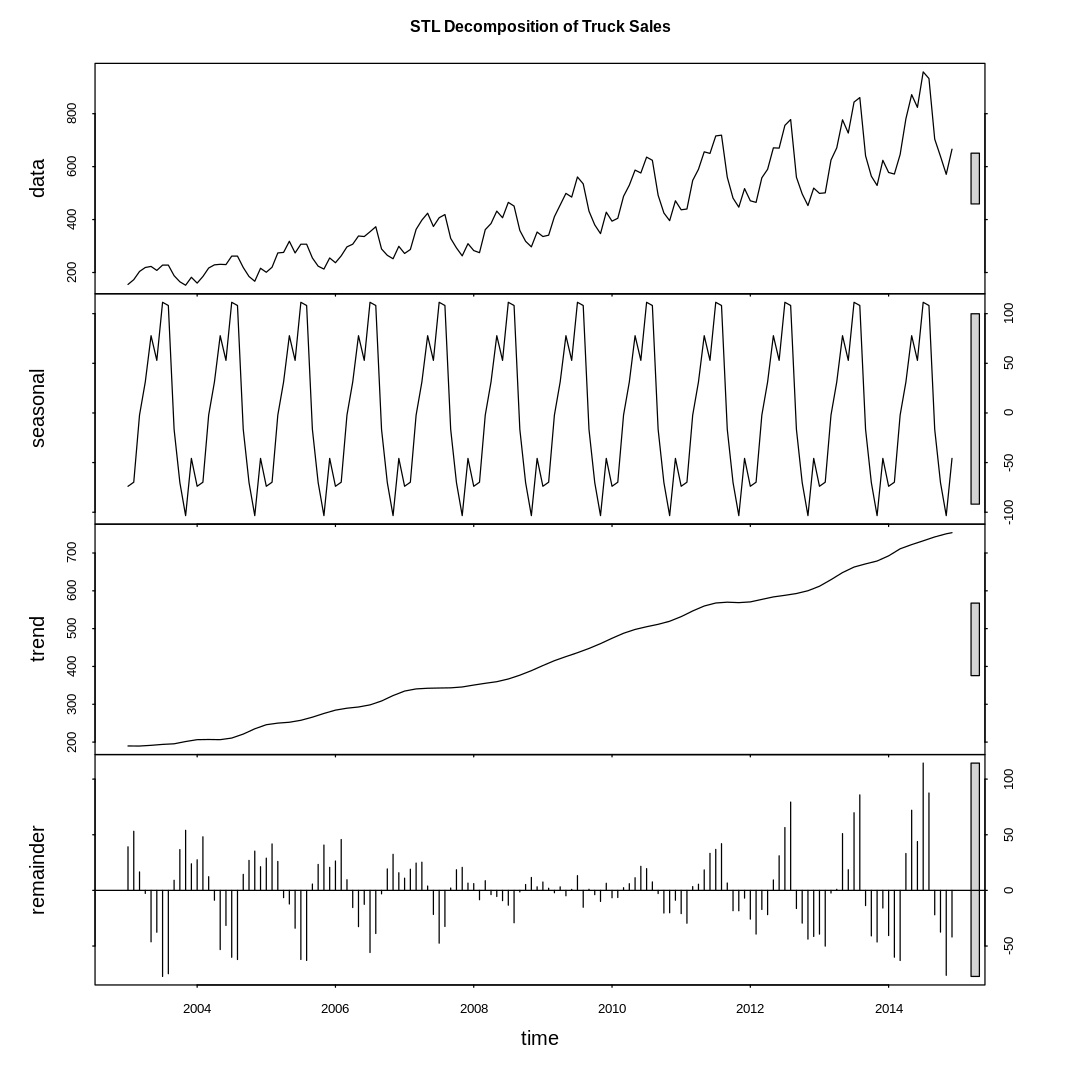

In [68]:

trucks_stl_result <- stl(ts_data, s.window = 'periodic')
plot(trucks_stl_result, main = 'STL Decomposition of Truck Sales')



1-Seasonal Component (seasonal):

* A strong seasonal pattern is evident, indicating periodic variations that repeat consistently.


2-Trend Component (trend):

* The trend line shows a steady increase in truck sales over the years.

3- Remainder Component (remainder/residuals)

* Residuals appear randomly distributed, with some variations increasing towards the later years


Interpretation:

*   The data has a clear seasonality and trend
*   In forecasting,I  have to consider removing the seasonality and modeling the trend separately.







##1.5- Splitting the Data into train and test

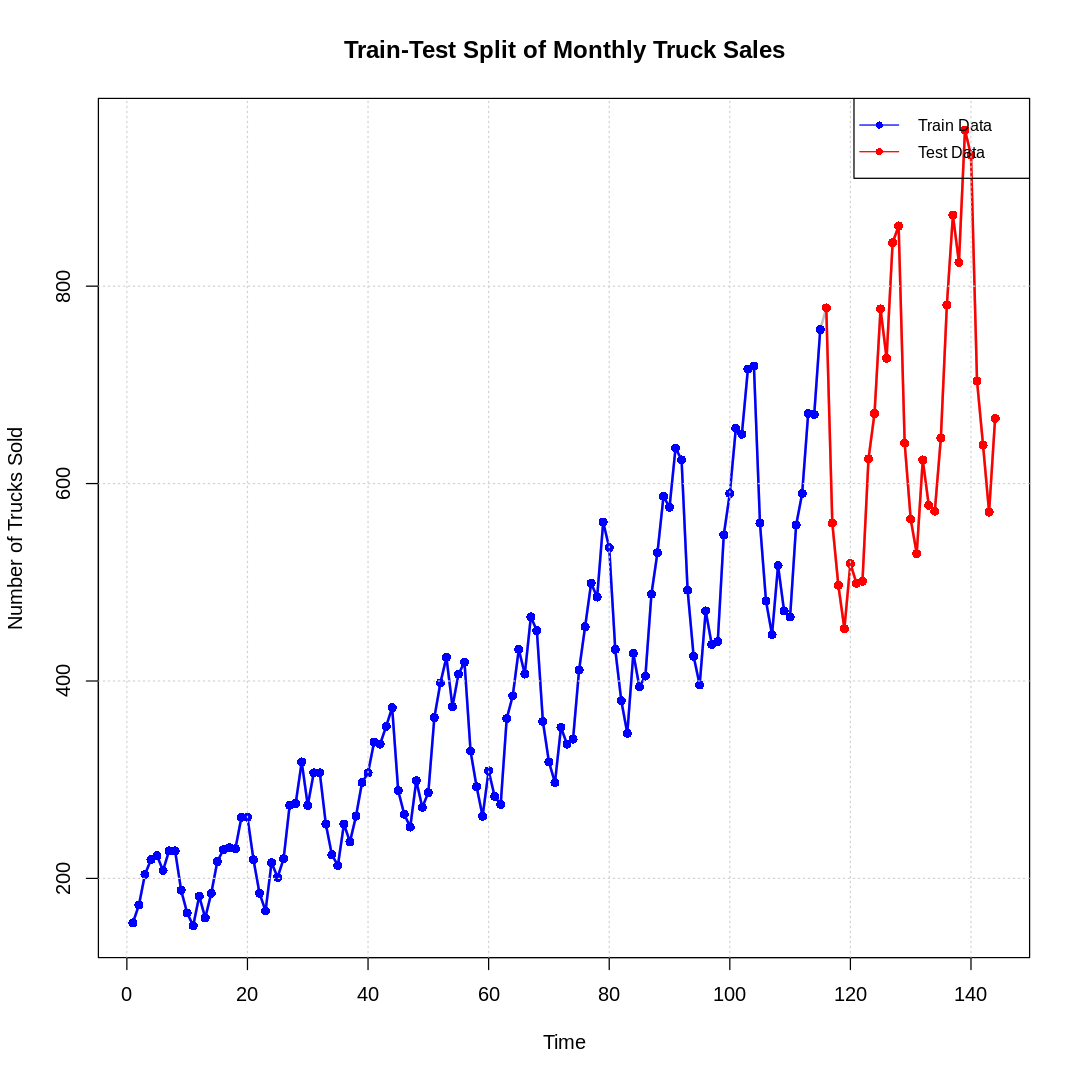

In [69]:

library(ggplot2)


train_size <- floor(0.8 * length(ts_data))
train_data <- ts_data[1:train_size]
test_data <- ts_data[(train_size + 1):144]

# Create time index
time_index <- 1:length(ts_data)
train_index <- time_index[1:train_size]
test_index <- time_index[(train_size + 1):length(ts_data)]


plot(time_index, ts_data, type="o", col="gray", lwd=2, pch=16,
     xlab="Time", ylab="Number of Trucks Sold",
     main="Train-Test Split of Monthly Truck Sales")
points(train_index, train_data, col="blue", type="o", lwd=2, pch=16)
points(test_index, test_data, col="red", type="o", lwd=2, pch=16)
legend("topright", legend=c("Train Data", "Test Data"),
       col=c("blue", "red"), pch=16, lty=1, cex=0.8)
grid()



##1.6- Variance Stabilization
For data stabilization, we will apply the Box-Cox transformation by determining the optimal value of 𝜆 , using the maximum likelihood estimation (MLE) method. This transformation helps stabilize the variance and improve stationarity

Warning message:
“In lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) :
 extra argument ‘main’ will be disregarded”


[1] "Best Lambda: 0.0300000000000002"


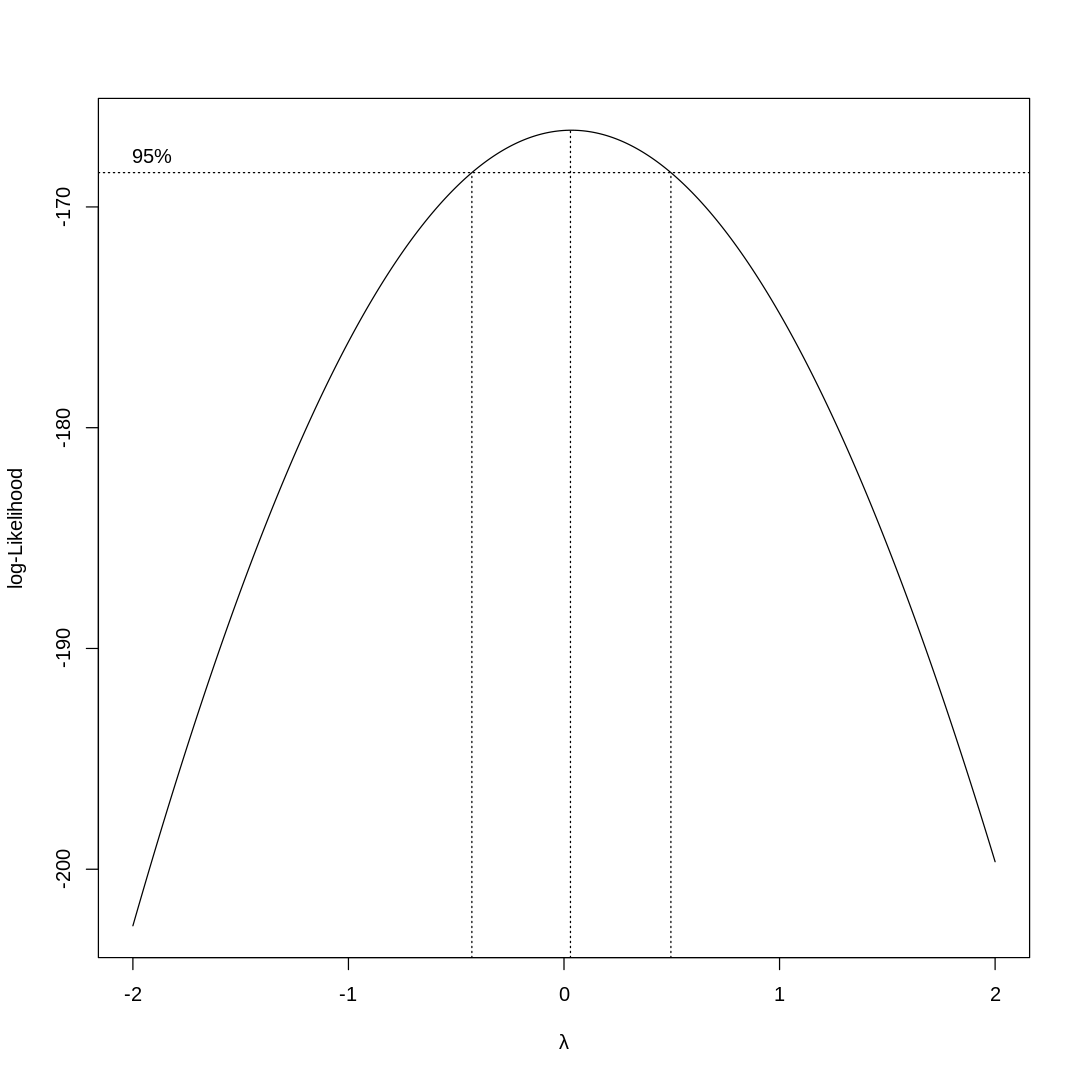

In [70]:
library(MASS)


lm_model <- lm(train_data ~ 1)


boxcox_result <- boxcox(lm_model, lambda = seq(-2, 2, 0.01),
                        main = "Box-Cox Log-Likelihood Plot")


best_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Best Lambda:", best_lambda))



In [71]:
# Confidence interval: values where log-likelihood is within 95% of the max
ci <- boxcox_result$x[boxcox_result$y > max(boxcox_result$y) - qchisq(0.95, df=1)/2]


print(paste("Confidence Interval for Lambda: [", min(ci), ",", max(ci), "]"))



[1] "Confidence Interval for Lambda: [ -0.42 , 0.49 ]"


As you can see, the estimated λ value is 0.03, which is close to 0. Since 0 is within the confidence interval, we apply the logarithmic transformation, a common approach in time series analysis to stabilize variance and improve stationarity.

In [72]:
log_ts_data <- log(train_data)
print(head(log_ts_data))


[1] 5.043425 5.153292 5.318120 5.389072 5.407172 5.337538


##1.7- Plotting the data after the Box-cox Transformation

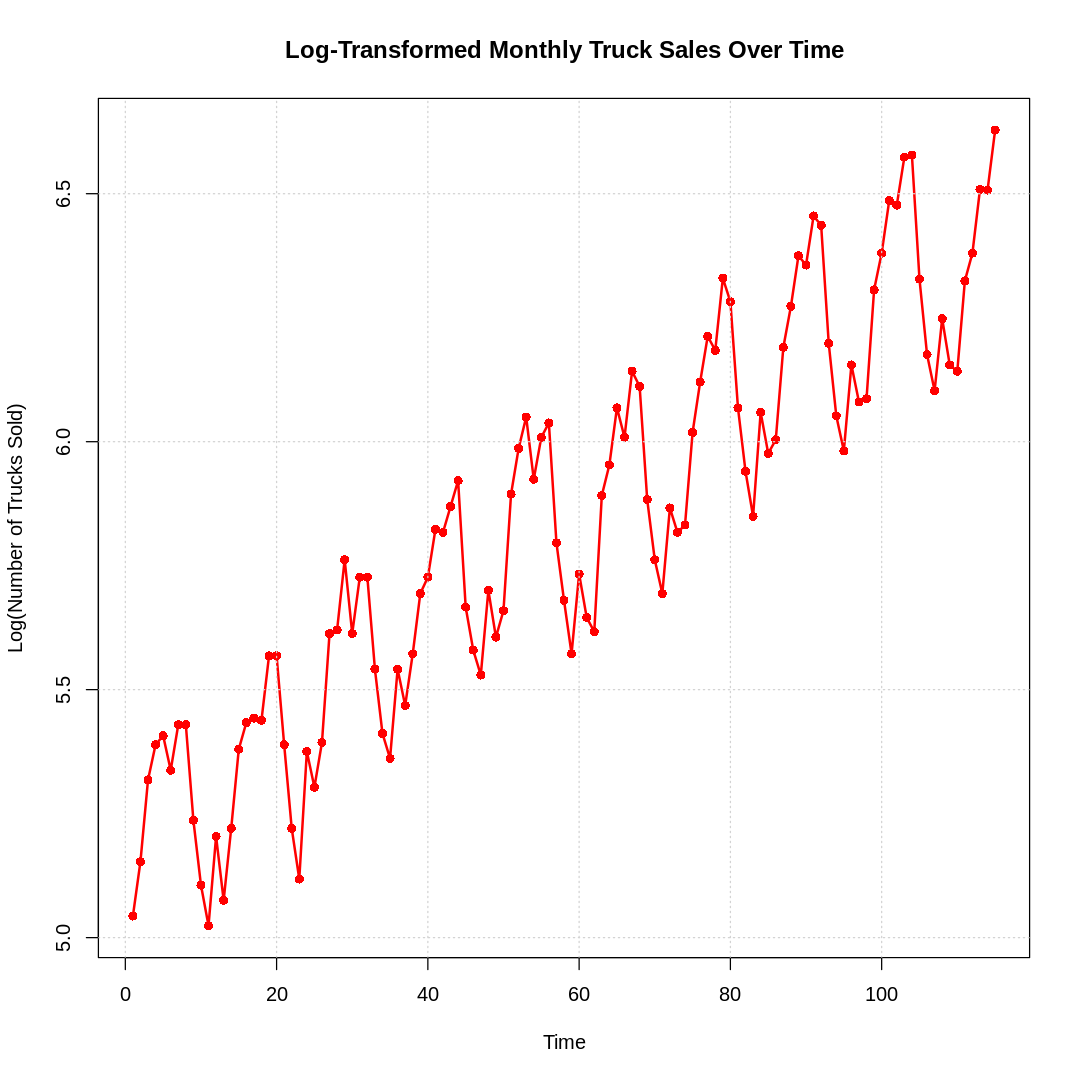

In [73]:

plot(log_ts_data, type="o", col="red", lwd=2, pch=16,
     xlab="Time", ylab="Log(Number of Trucks Sold)",
     main="Log-Transformed Monthly Truck Sales Over Time")
grid()



#2- Model Specifications

##2.1- Check Stationarity
to check stationaritywe will perform both :

*   the Augmented Dickey-Fuller (ADF)
*   test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS)


###2.1.1- ADF TEST :
We do the ADF test to find the stochastic trend

In [74]:
adf.test(log_ts_data)


Warning message in adf.test(log_ts_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  log_ts_data
Dickey-Fuller = -8.834, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


Since the p-value < 0.05 we reject H0 and data is stationary , it doesn't have stochastic trend

###2.1.2- KPSS TEST :
We use to find the deterministic trend , the one who is releted with time . not from the autoregressive   

*  Null Hypothesis H0 : The time series is stationary around a deterministic trend (trend-stationary).


*   Alternative Hypothesis H1 : The time series is non-stationary due to the presence of a unit root.



In [75]:
kpss_result <- kpss.test(log_ts_data)
print(kpss_result)



Warning message in kpss.test(log_ts_data):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  log_ts_data
KPSS Level = 2.202, Truncation lag parameter = 4, p-value = 0.01



Since p-value < 0.05 we reject H0 ( The time series is stationary) , so the data is not stationary and it has a deterministic trend

###2.1.3- How to Remove the deterministic trend
The best way to remove a deterministic trend is by using a regression model. Since our data exhibits a linear trend, applying a linear regression model is a suitable choice.

Steps :    

1.   Fit a Linear Regression Model
2.   Extract the Residuals
3.   Perform Time Series Analysis on Residuals

By working with the residuals instead of the original data, we ensure that the deterministic trend is removed, allowing for better modeling

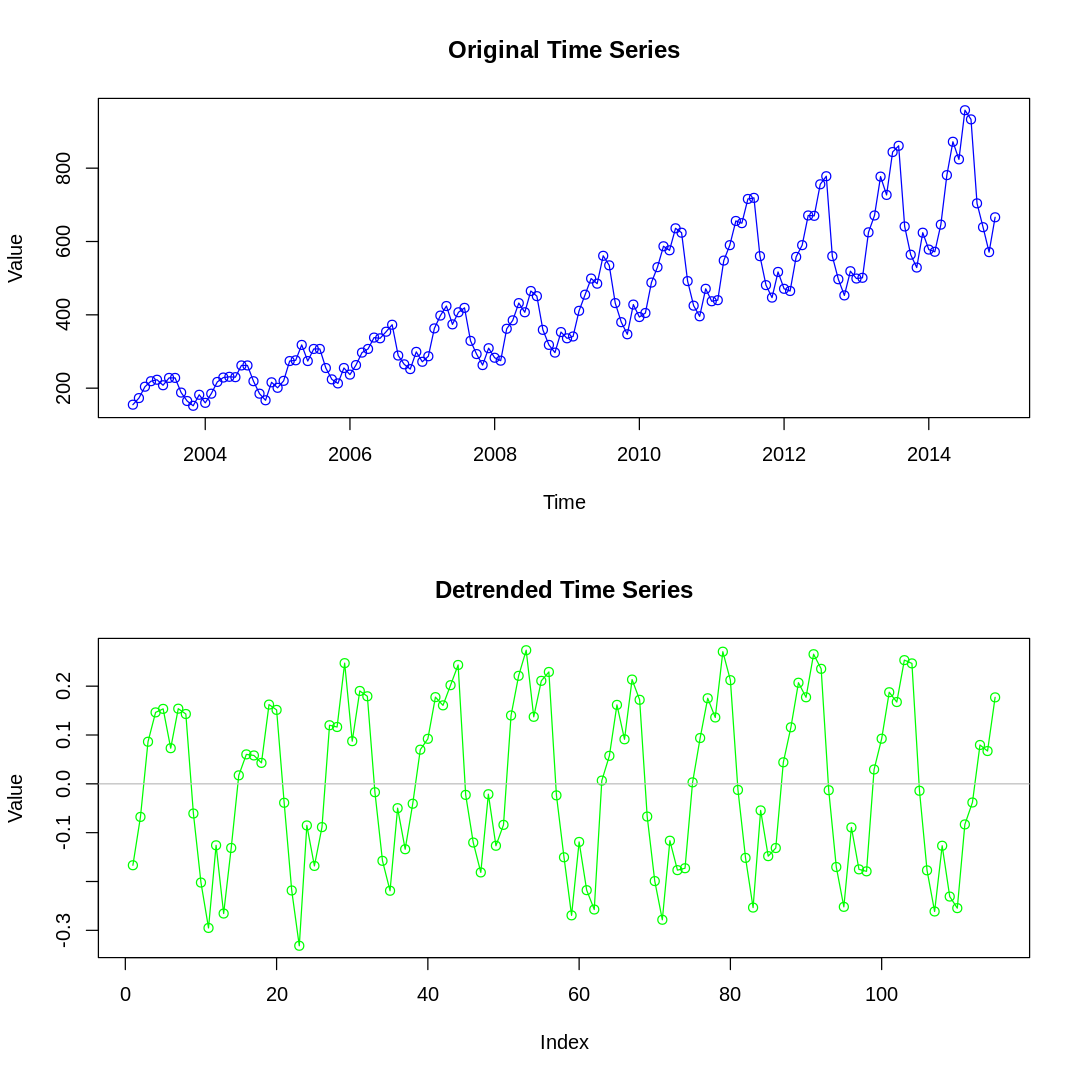

In [76]:

time_index <- 1:length(log_ts_data)


trend_model <- lm(log_ts_data ~ time_index)


trend_component <- trend_model$fitted.values


detrended_series <- log_ts_data - trend_component


par(mfrow=c(2,1))

plot(ts_data, type="o", col="blue", main="Original Time Series", ylab="Value")
lines(trend_component, col="red", lwd=2)

plot(detrended_series, type="o", col="green", main="Detrended Time Series", ylab="Value")
abline(h=0, col="gray")

par(mfrow=c(1,1))


Now, as observed from the graph, the linear trend has been successfully removed, leaving behind a detrended series. This confirms that our regression model effectively captured and eliminated the deterministic trend

###2.1.4- Checking stationarity after removing the deterministic trend

In [77]:
kpss.test(detrended_series, null = "Level")


Warning message in kpss.test(detrended_series, null = "Level"):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  detrended_series
KPSS Level = 0.023388, Truncation lag parameter = 4, p-value = 0.1


the p-value > 0.05 we accept H0 , so data is stationary

##2.1.5- apply saisonal diffrencing
Since we observe clear seasonality occurring every 12 months, applying seasonal differencing is necessary to remove it.

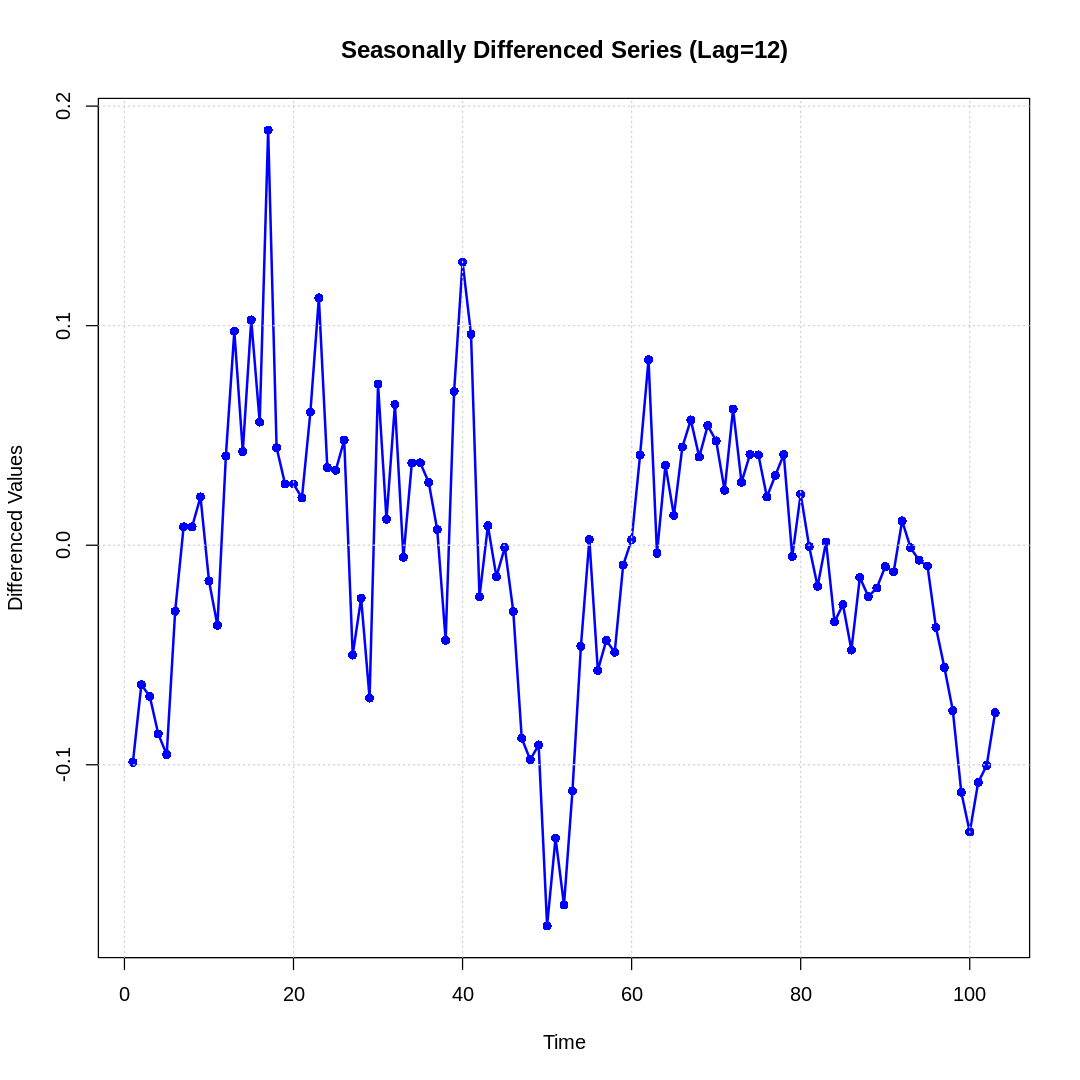

In [78]:
# Apply seasonal differencing (D=1, lag=12)
seasonal_diff_series <- diff(detrended_series, lag=12)

# Plot the differenced series
plot(seasonal_diff_series, type="o", col="blue", lwd=2, pch=16,
     xlab="Time", ylab="Differenced Values",
     main="Seasonally Differenced Series (Lag=12)")
grid()



###2.1.5.1- ADF TEST ON DIFFRENCED SERIE

In [79]:
library(tseries)

adf_result <- adf.test(seasonal_diff_series)
print(adf_result)



	Augmented Dickey-Fuller Test

data:  seasonal_diff_series
Dickey-Fuller = -2.8377, Lag order = 4, p-value = 0.2294
alternative hypothesis: stationary



p-value > 0.05 so data is not stationary
But from the graph we notice that there is no saisonality , So we will aply first diffrence d=1

##2.1.6- Apply first Diffrence

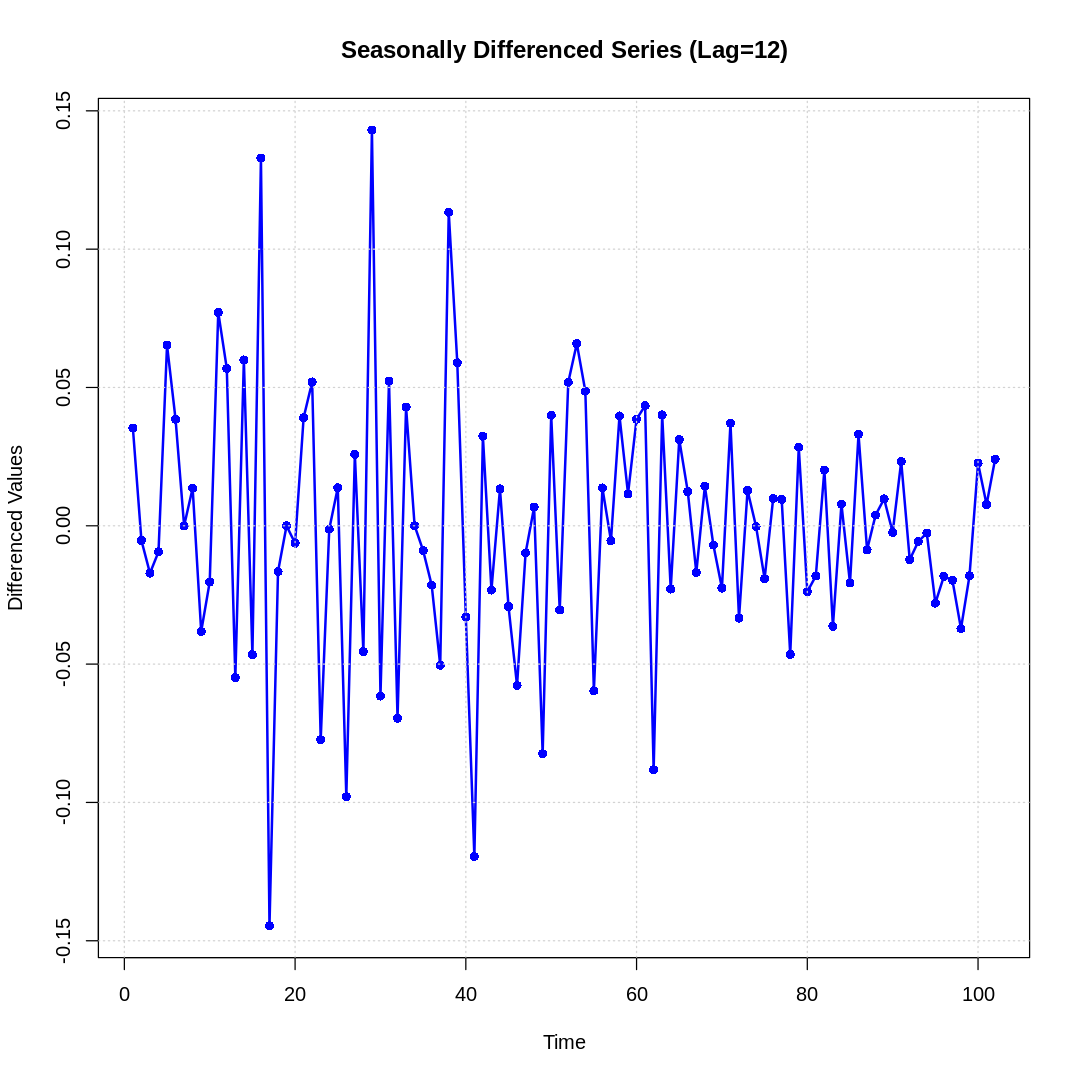

In [80]:

trend_diff <- diff(seasonal_diff_series)


plot(trend_diff, type="o", col="blue", lwd=2, pch=16,
     xlab="Time", ylab="Differenced Values",
     main="Seasonally Differenced Series (Lag=12)")
grid()



from the graph , it looks stationary , there is no a clear trend or saisonality , but we still have to confirm using ADF TEST


adf_result <- adf.test(trend_diff)
print(adf_result)

p-value < 0.05 so the data is stationary , and ready for modeling

#3- Condidates models
Since we applied seasonal differencing with a lag of 12 (𝐷=1) and a first differencing (d=1), we are considering a SARIMA model:
SARIMA(p,1,q)×(P,1,Q,12)


##3.1 ACF && PACF :

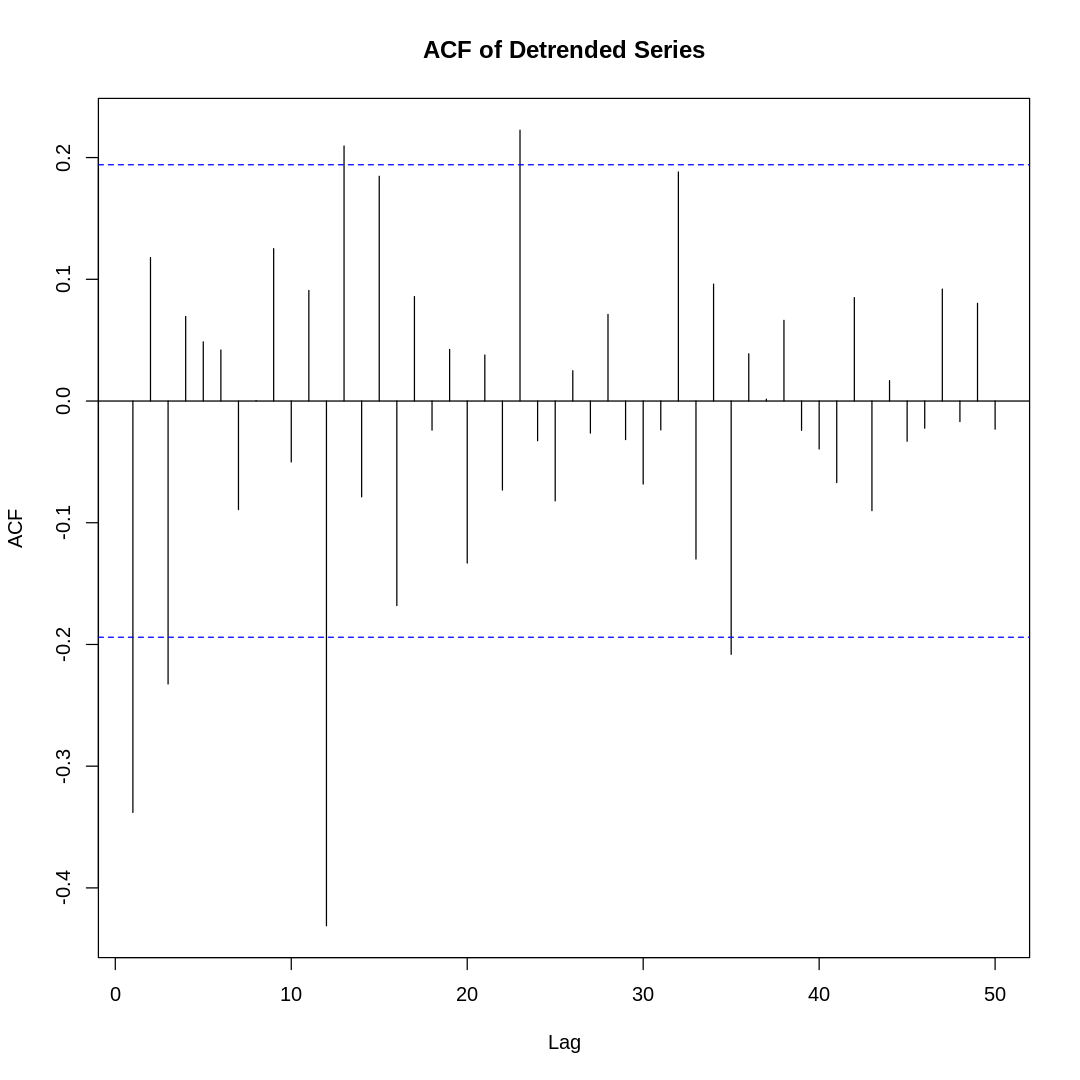

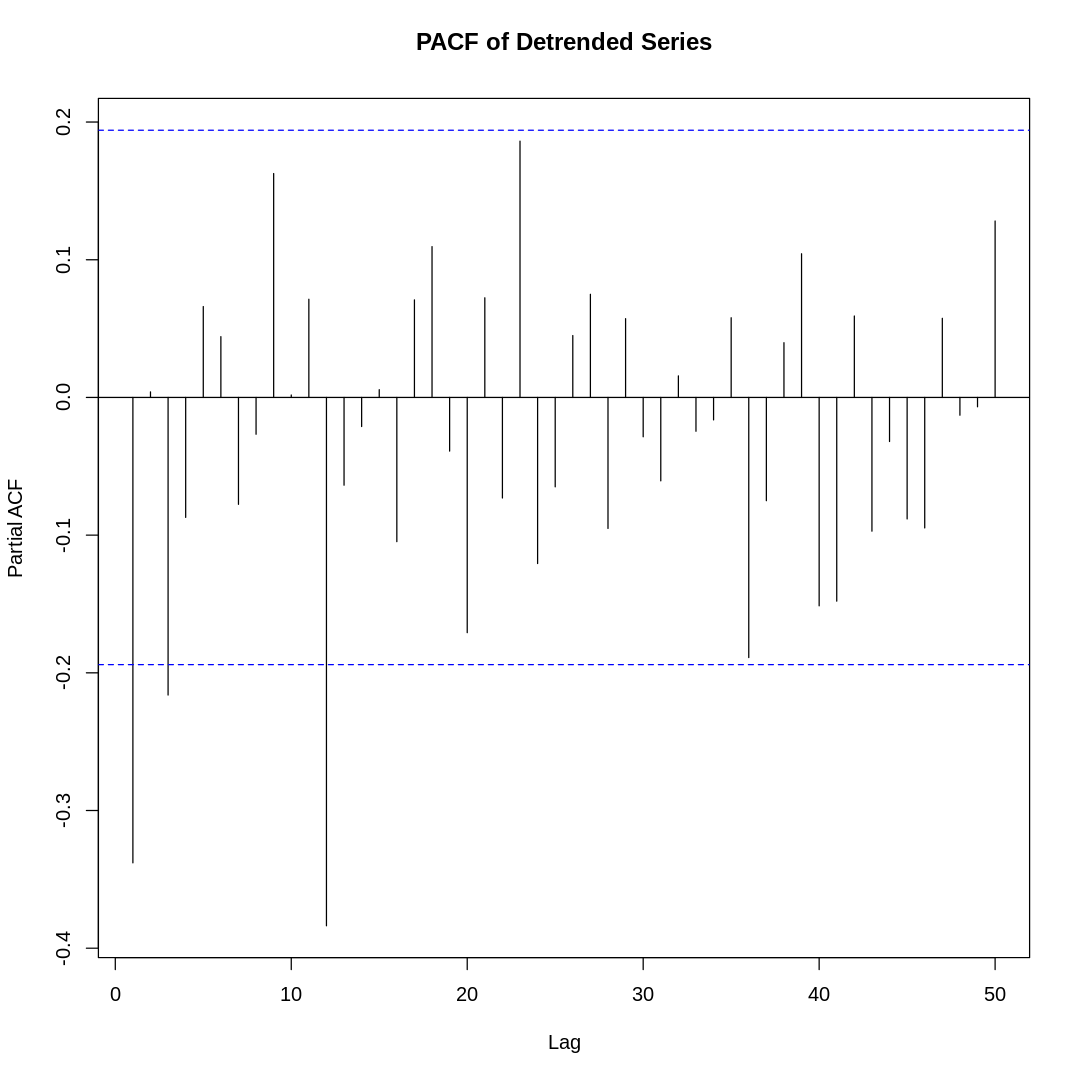

In [81]:
library(forecast)


par(mfrow=c(1,1))
acf(trend_diff,lag.max = 50, main="ACF of Detrended Series")
pacf(trend_diff,lag.max = 50, main="PACF of Detrended Series")
par(mfrow=c(1,1))


From the ACF plot, we can determine possible values for the non-seasonal MA (q) and the seasonal MA (Q) terms:
*   One possibility is that the ACF cuts off after lag 1, treating the remaining lags as noise. This suggests q=1
*   and there other possibility for q=3

Seasonal MA (𝑄) Selection:

*   The ACF for the seasonal component shows a clear cutoff after the second seasonal multiplier (lag 24).
*   this Suggest Q=2 .







From the PACF plot, we can determine possible values for the non-seasonal AR (q) and the seasonal AR (Q) terms:
*   One possibility is that the ACF cuts off after lag 1, treating the remaining lags as noise. This suggests q=1
*   and there other possibility for q=3

Seasonal AR (𝑄) Selection:

*   The ACF for the seasonal component shows a clear cutoff after the second seasonal multiplier (lag 12).
*   this Suggest Q=1 .



SO the possible Model
SARIMA(3,1,3)*(1,1,2,12),
SARIMA(1,1,3)*(1,1,2,12),
SARIMA(1,1,1)*(1,1,2,12),
SARIMA(3,1,1)*(1,1,2,12)





##3.2- USE BIC

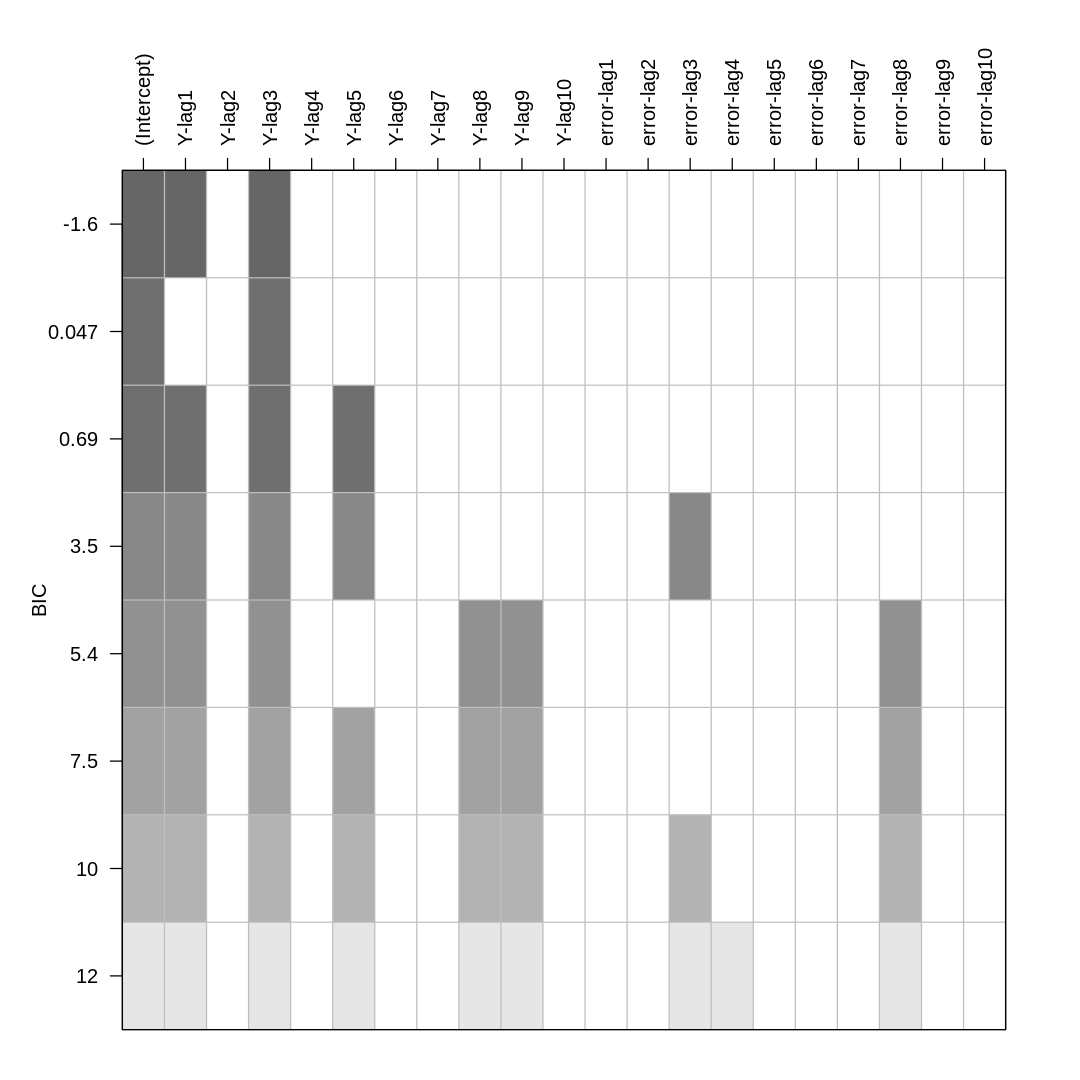

In [82]:
library(TSA)
plot(armasubsets(trend_diff, 10, 10))


this suggest for the non-saisonal part ARIMA(3,1,0)

so our condidates model
SARIMA(3,1,3)(1,1,2,12), SARIMA(1,1,3)(1,1,2,12), SARIMA(1,1,1)(1,1,2,12), SARIMA(3,1,1)(1,1,2,12) , SARIMA(3,1,0)(1,1,2,12)


##3.3-choose best model base on AIC AND BIC

In [83]:

library(forecast)


tss_data <- ts(detrended_series, frequency = 12)


models <- list(
  SARIMA_3_1_3 = Arima(tss_data, order = c(3,1,3), seasonal = c(1,1,2)),
  SARIMA_1_1_3 = Arima(tss_data, order = c(1,1,3), seasonal = c(1,1,2)),
  SARIMA_3_1_1 = Arima(tss_data, order = c(3,1,1), seasonal = c(1,1,2)),
  SARIMA_3_1_0 = Arima(tss_data, order = c(3,1,0), seasonal = c(1,1,2))
)


model_results <- data.frame(
  Model = names(models),
  AIC = sapply(models, AIC),
  BIC = sapply(models, BIC)
)


model_results <- model_results[order(model_results$AIC), ]
print(model_results)


best_model <- models[[which.min(model_results$AIC)]]
summary(best_model)



                    Model       AIC       BIC
SARIMA_3_1_0 SARIMA_3_1_0 -366.8525 -348.4777
SARIMA_1_1_3 SARIMA_1_1_3 -366.6730 -345.6732
SARIMA_3_1_1 SARIMA_3_1_1 -366.1094 -345.1096
SARIMA_3_1_3 SARIMA_3_1_3 -363.5601 -337.3103


Series: tss_data 
ARIMA(3,1,3)(1,1,2)[12] 

Coefficients:
          ar1     ar2     ar3     ma1      ma2      ma3     sar1    sma1
      -0.8096  0.7007  0.5839  0.4479  -0.9706  -0.4757  -0.9940  0.4471
s.e.   0.3618  0.1401  0.2492  0.4597   0.2180   0.4223   0.0802  0.1765
         sma2
      -0.5219
s.e.   0.1305

sigma^2 = 0.001357:  log likelihood = 191.78
AIC=-363.56   AICc=-361.14   BIC=-337.31

Training set error measures:
                        ME      RMSE       MAE       MPE     MAPE      MASE
Training set -0.0001027906 0.0331239 0.0240473 -1.536877 41.76924 0.4906204
                     ACF1
Training set -0.008714982

We will choose SARIMA(3,1,0)*(1,1,2,12) since it has the lower AIC BIC values

#**5-Fitting and Diagnostics**



In [84]:

fit <- Arima(detrended_series, order=c(3,1,0), seasonal=list(order=c(1,1,2), period=12))


residuals_arima <- residuals(fit)


summary(residuals_arima)


      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.1217517 -0.0203133 -0.0001452  0.0005866  0.0199202  0.1042426 

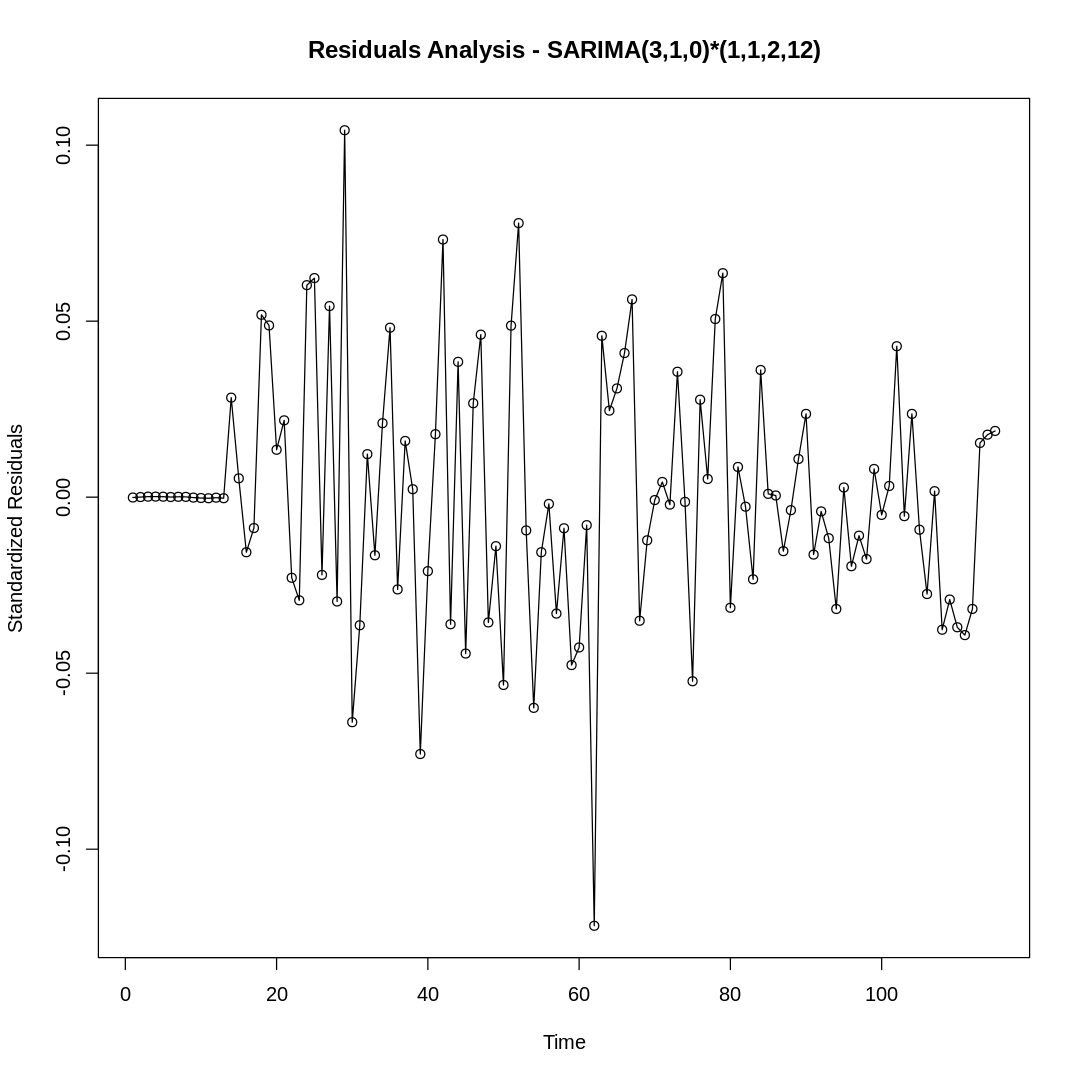

In [85]:

plot(residuals_arima, type = "o", ylab = "Standardized Residuals", main = "Residuals Analysis - SARIMA(3,1,0)*(1,1,2,12)")



##5.1- ACF AND PACF OF RESIDUALS

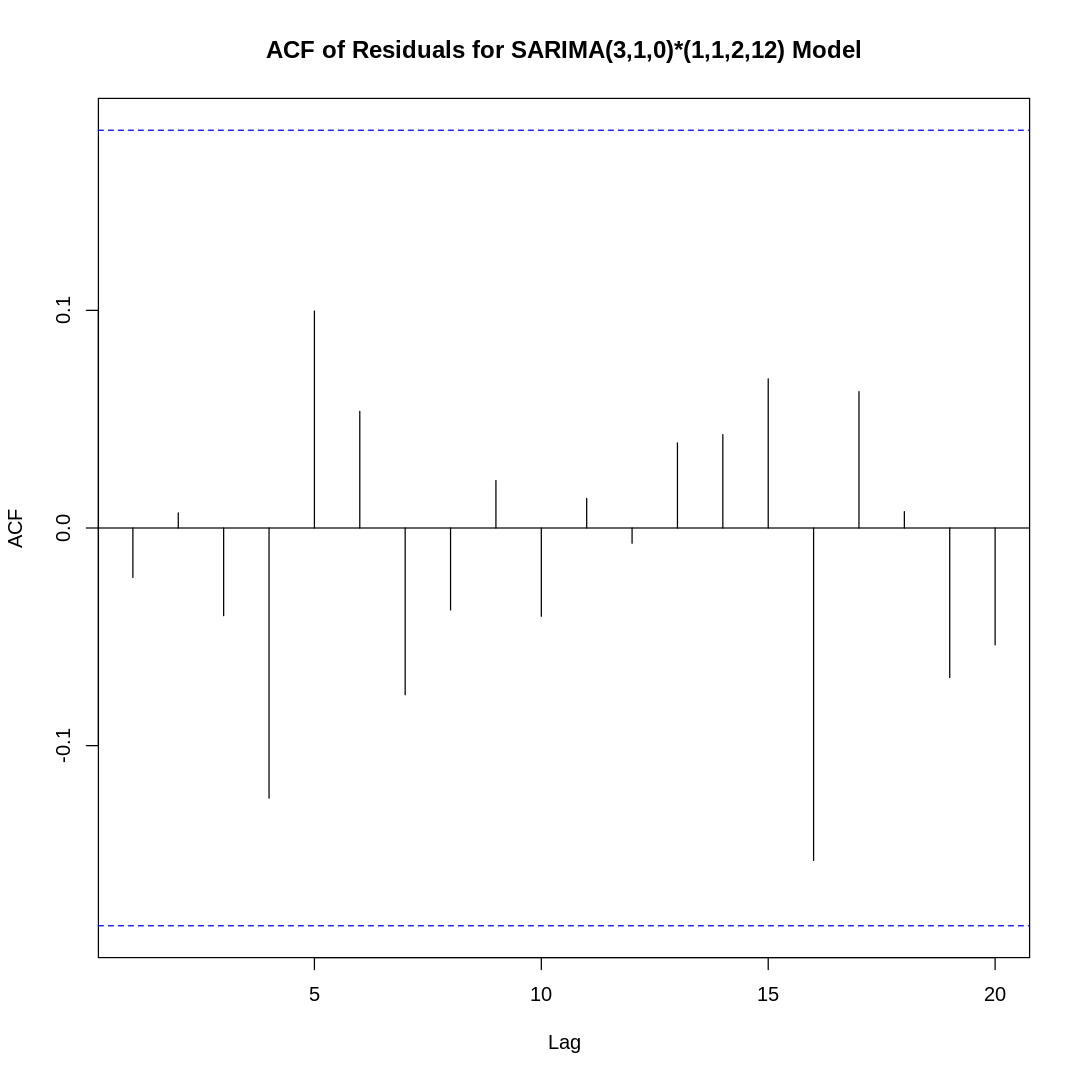

In [86]:
acf(residuals_arima, main = "ACF of Residuals for SARIMA(3,1,0)*(1,1,2,12) Model")


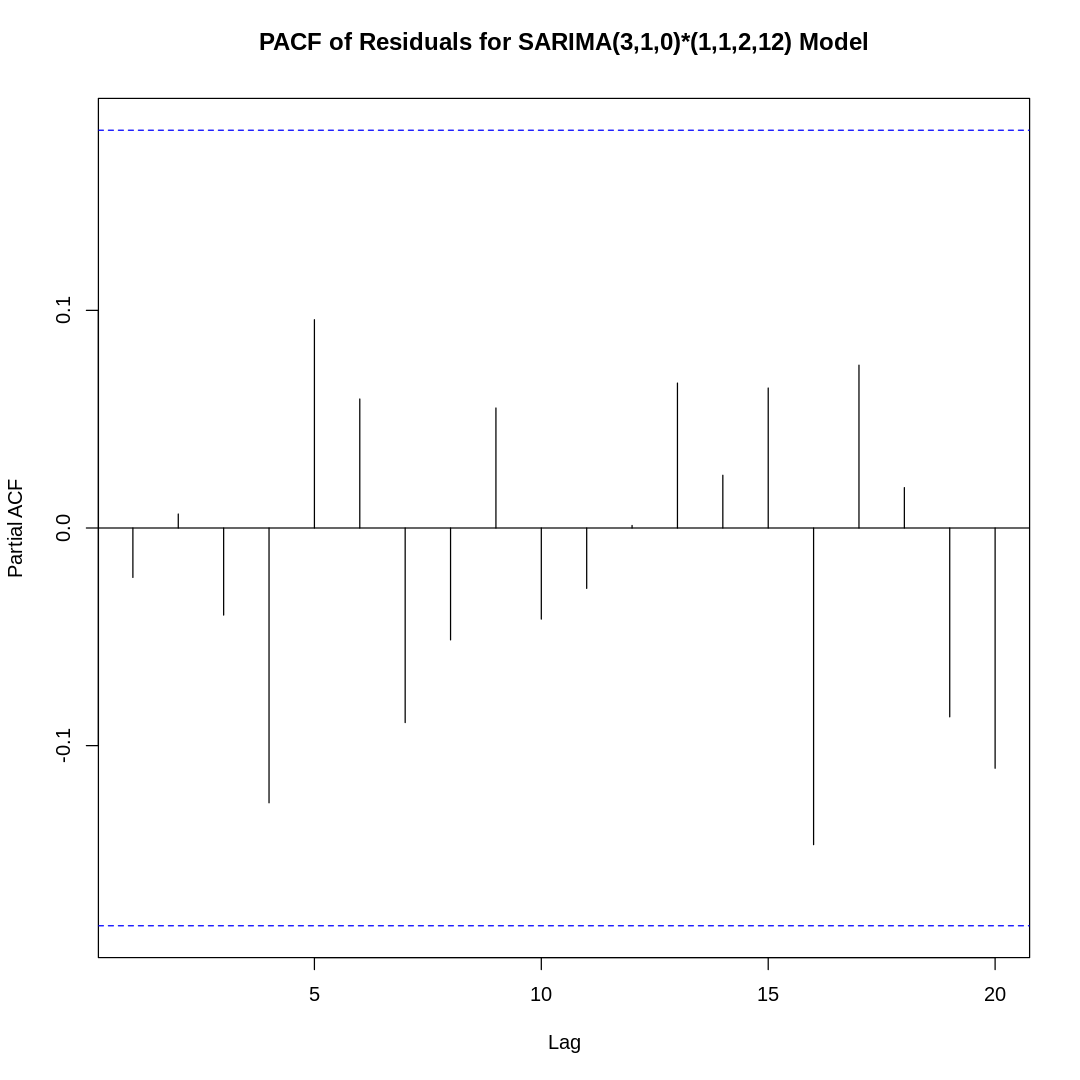

In [87]:
pacf(residuals_arima, main = "PACF of Residuals for SARIMA(3,1,0)*(1,1,2,12) Model")


we observed that all lags fall within the confidence interval. This indicates that there are no significant autocorrelations or partial autocorrelations in the residuals.

##5.2- Runs test

In [88]:
runs(residuals_arima)

$pvalue
[1] 0.269

$observed.runs
[1] 52

$expected.runs
[1] 58.3913

$n1
[1] 60

$n2
[1] 55

$k
[1] 0

Since the p-value is high (> 0.05), there is no significant pattern in the residuals. This means that the residuals do not show strong autocorrelation, suggesting that the model adequately captures the structure in the data.

##5.3- QQ plot and histogram

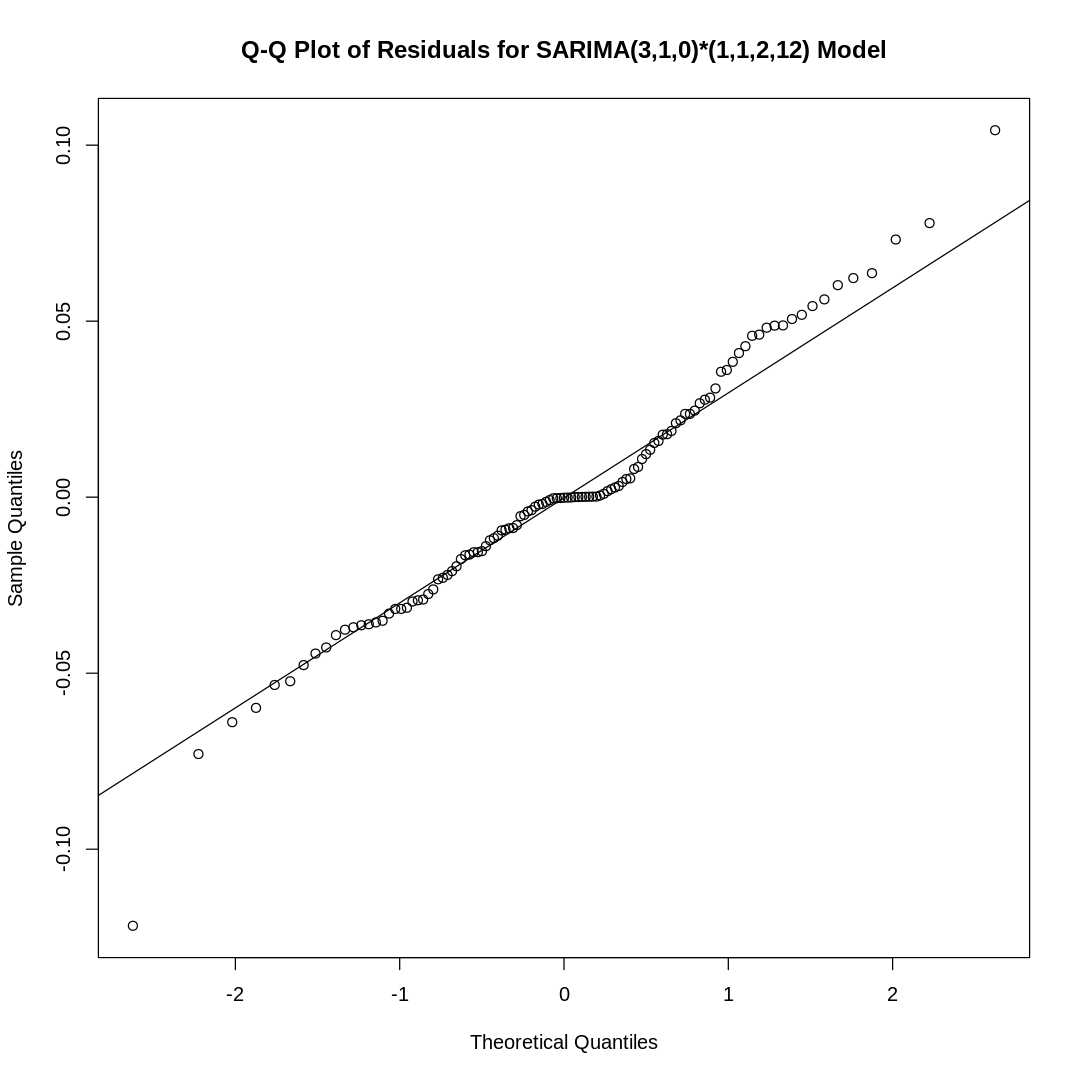

In [89]:
qqnorm(residuals_arima, main = "Q-Q Plot of Residuals for SARIMA(3,1,0)*(1,1,2,12) Model")
qqline(residuals_arima)



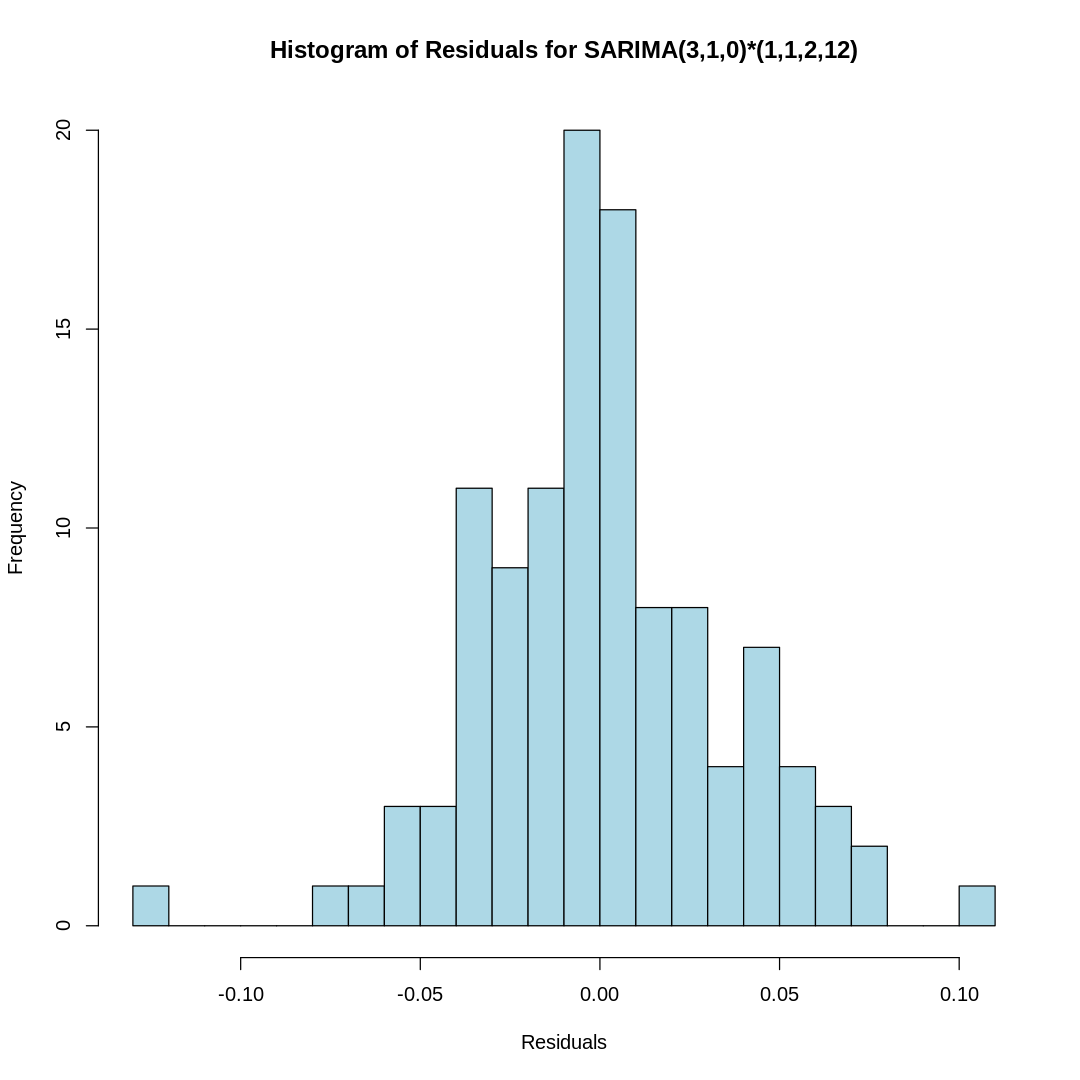

In [90]:
hist(residuals_arima, main = "Histogram of Residuals for SARIMA(3,1,0)*(1,1,2,12)",
     xlab = "Residuals", col = "lightblue", border = "black", breaks = 20)



From the QQ plot and histogram, the residuals appear to follow a normal distribution overall, but some points deviate from the normality assumption. To confirm this statistically, we conducted the Shapiro-Wilk test.

##5.4- Shapiro-Wilk Test for Normality of Residuals

In [91]:
shapiro.test(residuals_arima)


	Shapiro-Wilk normality test

data:  residuals_arima
W = 0.9794, p-value = 0.0737


Since p > 0.05, the residuals do not significantly deviate from normality, which supports the assumption of normality in your SARIMA model. This suggests that the model is well-specifie

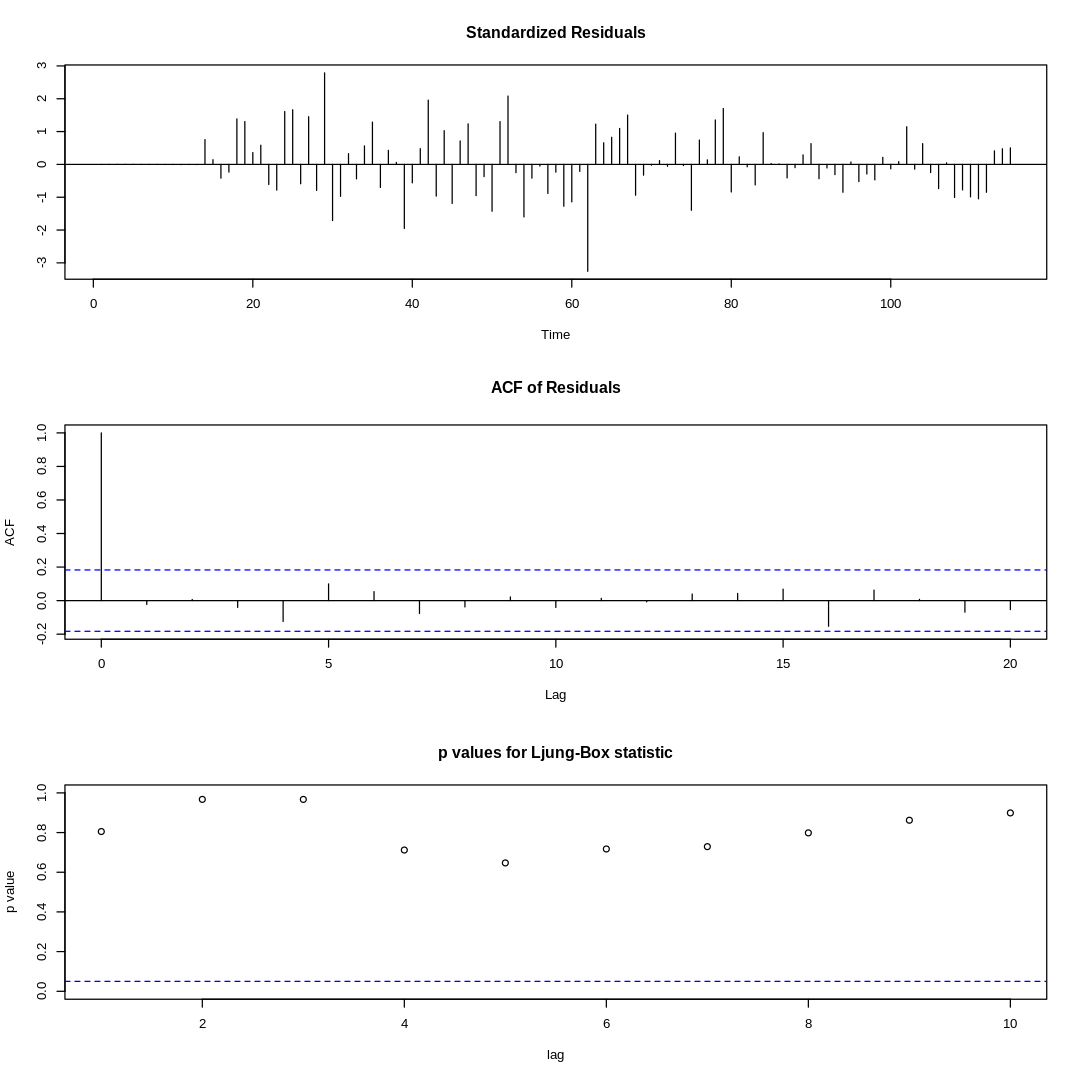

In [92]:
tsdiag(fit)

In [93]:
Box.test(residuals_arima, lag = 12, type = "Ljung-Box")



	Box-Ljung test

data:  residuals_arima
X-squared = 4.9112, df = 12, p-value = 0.9609


Since p-value > 0.05, we fail to reject H0(null hypothesis). This means that there is no significant autocorrelation in the residuals, indicating that the model has captured the dependencies in the data well.

##5.5- Conclusion of the residual of the best model :     
 The residuals of the model SARIMA(3,1,0)*(1,1,2,12) are approximately normal, uncorrelated, and randomly distributed, indicating that the SARIMA model is well-fitted and suitable for forecasting.

#6- Forcasting

In [94]:

arima_model <- Arima(detrended_series,order=c(3,1,0) ,seasonal=list(order=c(1,1,2), period=12) )

# 3. Forecast
forecast_values <- forecast(arima_model, h = length(test_data))

print(forecast_values)


    Point Forecast       Lo 80        Hi 80       Lo 95        Hi 95
116    0.147226822  0.09901214  0.195441500  0.07348883  0.220964809
117   -0.103220080 -0.16112724 -0.045312915 -0.19178145 -0.014658714
118   -0.258476715 -0.32591532 -0.191038114 -0.36161516 -0.155338274
119   -0.341329960 -0.41415055 -0.268509371 -0.45269944 -0.229960479
120   -0.184334875 -0.26392423 -0.104745521 -0.30605629 -0.062613462
121   -0.275480396 -0.36075466 -0.190206134 -0.40589612 -0.145064667
122   -0.284113119 -0.37515490 -0.193071334 -0.42334951 -0.144876724
123   -0.094121669 -0.19024935  0.002006009 -0.24113627  0.052892928
124   -0.035090047 -0.13619988  0.066019789 -0.18972420  0.119544103
125    0.068226859 -0.03754370  0.173997421 -0.09353526  0.229988974
126    0.033847156 -0.07645078  0.144145097 -0.13483899  0.202533299
127    0.135610767  0.02100009  0.250221447 -0.03967114  0.310892676
128    0.110838057 -0.01506661  0.236742725 -0.08171652  0.303392630
129   -0.137900280 -0.27162901 -0.

##6.1 In this step, we combine the trend and seasonal components to generate the final forecast in the original scale
since we fiited our original data with linear model

In [95]:

forecast_trend <- predict(trend_model, newdata = data.frame(time_index = (train_size + 1):length(ts_data)))
train_size
length(ts_data)


[1] 115

[1] 144

##6.2 Converting Forecasts Back to the Original Scale (INVERS OF BOX-COX)
since we did a log transformation , we do exponontiel for the invers

In [96]:
final_forecast <- exp(forecast_values$mean + forecast_trend)



##6.3- FORCAST VS REAL VALUES

[1] 115
[1] 144
[1] 115
[1] 115
[1] 29
[1] 29
[1] 29


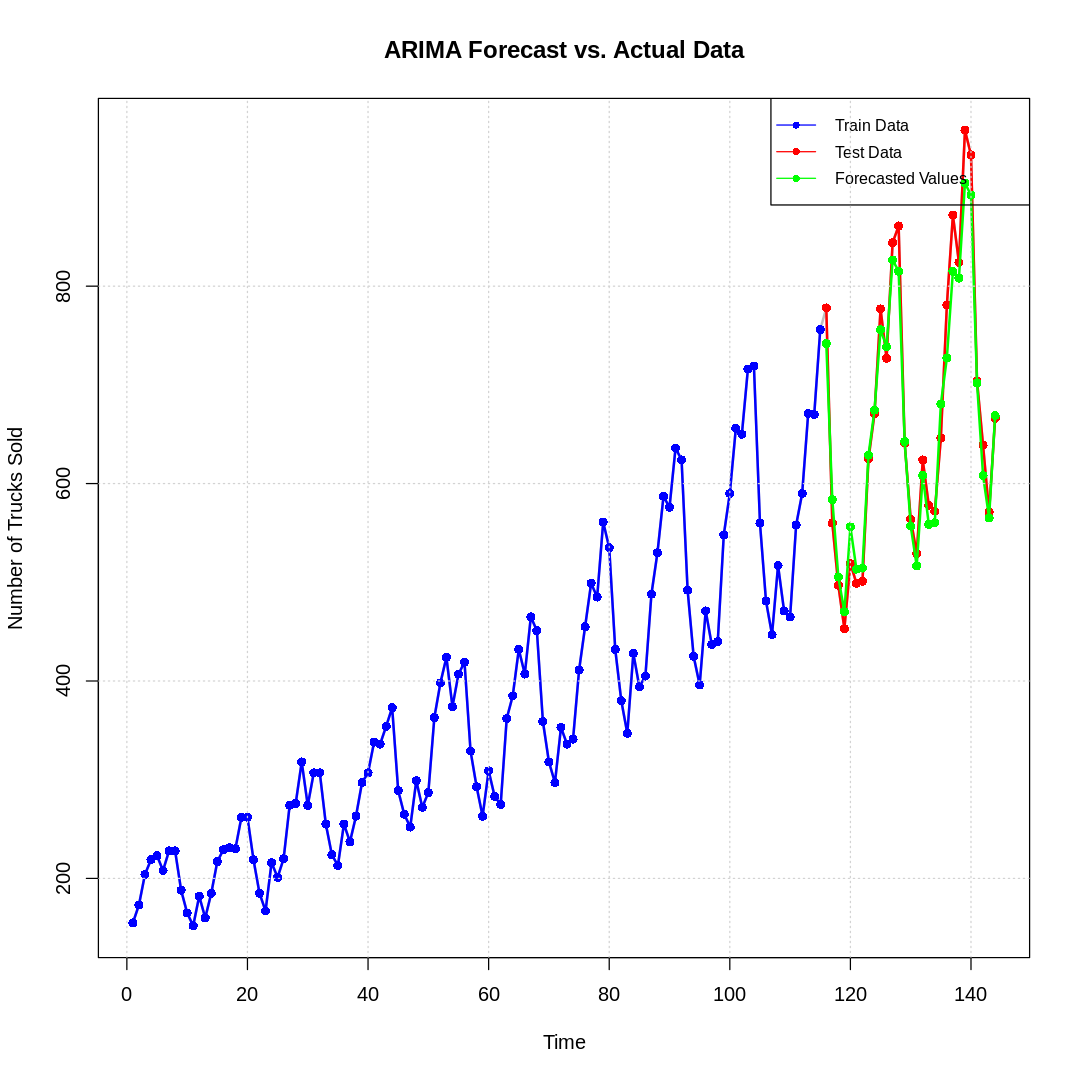

In [97]:

print(length(time_index))
print(length(ts_data))
print(length(train_index))
print(length(train_data))
print(length(test_index))
print(length(test_data))
print(length(final_forecast))

time_index <- 1:length(ts_data)
train_index <- time_index[1:train_size]
test_index <- time_index[(train_size + 1):144]


plot(time_index, ts_data, type="o", col="gray", lwd=2, pch=16,
     xlab="Time", ylab="Number of Trucks Sold",
     main="ARIMA Forecast vs. Actual Data")


points(train_index, train_data, col="blue", type="o", lwd=2, pch=16)


points(test_index, test_data, col="red", type="o", lwd=2, pch=16)


points(test_index, final_forecast, col="green", type="o", lwd=2, pch=16)


legend("topright", legend=c("Train Data", "Test Data", "Forecasted Values"),
       col=c("blue", "red", "green"), pch=16, lty=1, cex=0.8)

grid()


##6.4 Commenting on the graph :
We are seeing a very good result

*  The SARIMA forecast follows the same pattern as the actual data, effectively capturing both the seasonality and the trend of truck sales. The predicted values (green) align well with the test data (red), showing that the model understands the fluctuations and periodic variations present in the series.
*  Additionally, the forecasted values are well-fitted to the historical data, indicating that the ARIMA model successfully learns from past trends to make accurate predictions.
*  






##6.5- Evaluate the model

In [98]:
actual <- as.numeric(test_data)
predicted <- as.numeric(final_forecast)

mape_value <- mape(actual, predicted) * 100
rmse_value <- rmse(actual, predicted)
mae_value <- mae(actual, predicted)


cat("📊 Performance du modèle SARIMA 📊\n")
cat("MAPE  :", round(mape_value, 2), "%\n")
cat("RMSE  :", round(rmse_value, 2), "\n")
cat("MAE   :", round(mae_value, 2), "\n")


📊 Performance du modèle SARIMA 📊
MAPE  : 3.06 %
RMSE  : 26.97 
MAE   : 21.31 


MAPE (Mean Absolute Percentage Error) = 3.06%
A very low MAPE suggests that the model's predictions are highly accurate, with an average error of just 3.06% relative to actual values. This indicates excellent forecasting capability.

RMSE (Root Mean Squared Error) = 26.97 : the error magnitude is relatively low, meaning the model performs well in capturing variations.

MAE (Mean Absolute Error) = 21.31 : the value is kind of low MAE further confirms that the model produces consistent and reliable forecasts.

# Conclusion

In this project, we developed a SARIMA(3,1,0)(1,1,2,12) model to forecast truck sales. The model effectively captured both seasonality and trend, aligning closely with actual sales data. The forecasted values followed the same pattern as the observed data, demonstrating the model’s ability to generalize well.

Performance metrics such as MAPE (3.06%), RMSE (26.97), and MAE (21.31) indicate a highly accurate forecast. Additionally, the residual analysis confirmed that the errors were normally distributed and independent, validating the reliability of our model.

Overall, this model provides a strong predictive framework for truck sales, making it valuable for demand forecasting and strategic decision-making in the industry. 🚛